Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Detected Folders: ['0_zero', '1_one', '2_two', '3_three', '4_four', '5_five', '6_six', '7_seven', '8_eight', '9_nine', 'Untitled0.ipynb', 'add', 'div', 'mul', 'sub']
✅ Successfully loaded 8056 images with 14 unique labels.


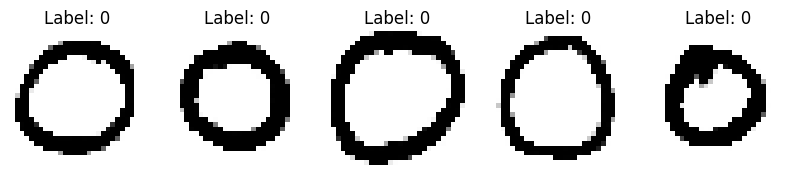

In [5]:
from google.colab import drive
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset path
dataset_path = "/content/drive/MyDrive/GujaratiHandwrittenNumber"

# Label mapping for digits and operators (updated for correct Gujarati mathematical symbols)
label_mapping = {'0_zero': 0, '1_one': 1, '2_two': 2, '3_three': 3, '4_four': 4,
                 '5_five': 5, '6_six': 6, '7_seven': 7, '8_eight': 8, '9_nine': 9,
                 'add': '+', 'sub': '-', 'mul': '×', 'div': '÷'}

# Function to load images with proper error handling
def load_images_from_folder(folder):
    images = []
    labels = []

    label_list = sorted(os.listdir(folder))  # Get all subfolders

    print("Detected Folders:", label_list)  # Debugging step

    for label in label_list:
        label_path = os.path.join(folder, label)

        if not os.path.isdir(label_path):  # Skip non-folder items
            continue

        if label not in label_mapping:  # Ensure label exists in mapping
            print(f"⚠ WARNING: Skipping unknown label '{label}'")
            continue

        for img_file in os.listdir(label_path):
            if img_file.startswith('.'):  # Skip system files
                continue

            img_path = os.path.join(label_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                print(f"❌ Error loading image: {img_path}")
                continue

            img = cv2.resize(img, (28, 28))  # Resize for CNN input
            images.append(img)
            labels.append(label_mapping[label])  # Correct label assignment

    return np.array(images), np.array(labels)

# Load dataset with verification
X, y = load_images_from_folder(dataset_path)

# Verify dataset size
print(f"✅ Successfully loaded {len(X)} images with {len(set(y))} unique labels.")

# Display sample images for verification
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X[i], cmap='gray')
    plt.title(f"Label: {y[i]}")
    plt.axis('off')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

# Normalize images (convert pixel values to range 0-1)
X = X / 255.0

# Reshape images for CNN input (adding channel dimension)
X = X.reshape(-1, 28, 28, 1)

# Convert labels to numeric format for model training
from tensorflow.keras.utils import to_categorical

# Handling Gujarati operator labels (+, -, ×, ÷) as categorical values
unique_labels = sorted(set(y))  # Ensure correct label ordering
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
y_numeric = np.array([label_to_index[label] for label in y])

# Split dataset into training (80%) & testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, random_state=42)

print(f"✅ Dataset prepared: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples.")

✅ Dataset prepared: 6444 training samples, 1612 test samples.


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation settings
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False  # Digits & operators shouldn't be flipped
)

# Apply augmentation to training data
datagen.fit(X_train)

print("✅ Data augmentation applied for training.")

✅ Data augmentation applied for training.


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define CNN architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),  # Helps prevent overfitting
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(len(unique_labels), activation='softmax')  # Output layer for multiple classes
])

# Compile CNN model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("✅ CNN model created successfully!")

✅ CNN model created successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=20, validation_data=(X_test, y_test))

print("✅ Model training completed!")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


202/202 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.4633 - loss: 1.6958 - val_accuracy: 0.0831 - val_loss: 3.8671
Epoch 2/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.8483 - loss: 0.4864 - val_accuracy: 0.5608 - val_loss: 1.5334
Epoch 3/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9012 - loss: 0.3244 - val_accuracy: 0.9529 - val_loss: 0.1446
Epoch 4/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.9156 - loss: 0.2616 - val_accuracy: 0.9739 - val_loss: 0.0904
Epoch 5/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.9363 - loss: 0.2067 - val_accuracy: 0.9280 - val_loss: 0.2139
Epoch 6/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.9310 - loss: 0.2264 - val_accuracy: 0.9826 - val_loss: 0.0550
Epoch 7/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.9380 - loss: 0.1954 - val_accuracy: 0.9603 - val_loss: 0.1388
Epoch 8/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.9449 - loss: 0.1929 - val_accurac

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9451 - loss: 0.1674
📊 Test Accuracy: 94.98%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


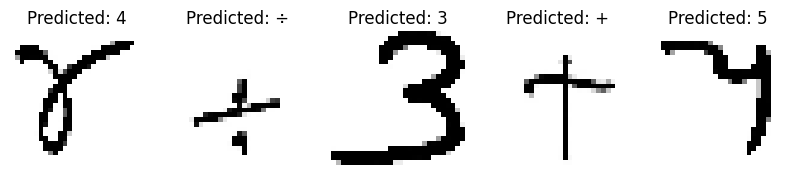

In [10]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"📊 Test Accuracy: {test_acc*100:.2f}%")

# Sample predictions
predictions = model.predict(X_test[:5])

plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Predicted: {unique_labels[np.argmax(predictions[i])]}")
    plt.axis('off')
plt.show()

In [14]:
# Save the trained model
model.save("handwritten_cnn_model.h5")
print("✅ Model saved successfully!")

✅ Model saved successfully!


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9451 - loss: 0.1674
📊 Test Accuracy: 94.98%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


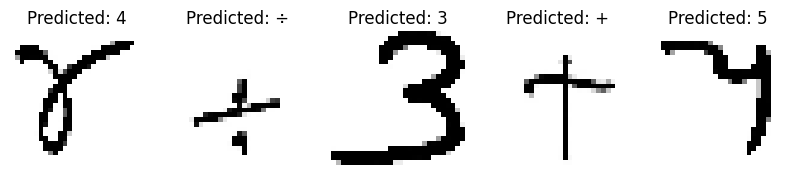

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


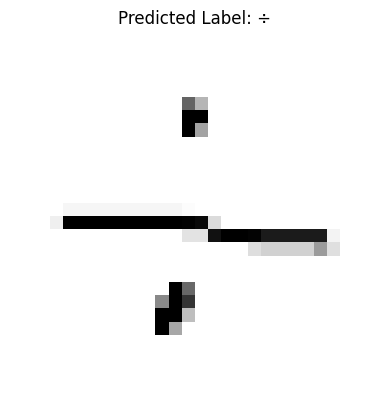

✅ Predicted Class: ÷


In [90]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load trained CNN model
model = tf.keras.models.load_model("handwritten_cnn_model.h5")  # Ensure correct model path

# **Evaluate Model Performance on Test Data**
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"📊 Test Accuracy: {test_acc*100:.2f}%")

# **Evaluate Sample Test Data (First 5 Images)**
predictions = model.predict(X_test[:5])

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Predicted: {unique_labels[np.argmax(predictions[i])]}")
    plt.axis('off')
plt.show()

# **NEW FEATURE: Test a Manually Inserted Image**
def predict_image(image_path):
    # Load image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Preprocess image (resize & normalize)
    img = cv2.resize(img, (28, 28))  # Ensure it matches model input size
    img = img / 255.0  # Normalize pixel values
    img = img.reshape(1, 28, 28, 1)  # Reshape for CNN

    # Make prediction
    prediction = model.predict(img)
    predicted_label = np.argmax(prediction)

    # Display result
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title(f"Predicted Label: {unique_labels[predicted_label]}")
    plt.axis('off')
    plt.show()

    print(f"✅ Predicted Class: {unique_labels[predicted_label]}")

# **Use the function to test an inserted image**
image_path = "/content/Screenshot 2025-06-05 171023.png"  # Replace with actual image path
predict_image(image_path)

✅ Filtered Contours: 3


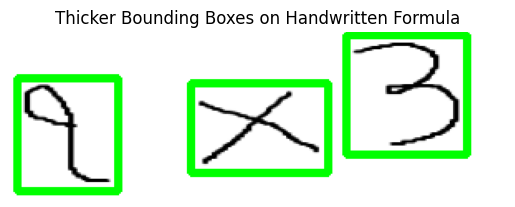

In [91]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load handwritten arithmetic formula image
image_path = "/content/1x3.png"  # Replace with actual path
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess image (resize & apply thresholding for better contour detection)
img = cv2.resize(img, (300, 100))  # Adjust dimensions as needed
_, img_thresh = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV)

# Find contours of digits and operators
contours, _ = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert image to color for drawing bounding boxes
img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# 🔥 Set a minimum contour area to filter small noise artifacts
MIN_CONTOUR_AREA = 50  # Adjust based on image size
valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > MIN_CONTOUR_AREA]

print(f"✅ Filtered Contours: {len(valid_contours)}")  # Debugging step

# 🔥 Increase bounding box thickness with padding
PADDING = 5  # Add padding to make boxes thicker and more noticeable

# Draw bounding boxes around **filtered** contours
for cnt in valid_contours:
    x, y, w, h = cv2.boundingRect(cnt)

    # Expand box size to make it thicker
    x -= PADDING
    y -= PADDING
    w += 2 * PADDING
    h += 2 * PADDING

    cv2.rectangle(img_color, (x, y), (x+w, y+h), (0, 255, 0), 4)  # Thicker green box

# Display final processed image
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title("Thicker Bounding Boxes on Handwritten Formula")
plt.axis('off')
plt.show()

In [92]:
# Detect contours for individual characters
contours, _ = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

segments = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    char_img = img_thresh[y:y+h, x:x+w]  # Crop each digit/operator
    char_img = cv2.resize(char_img, (28, 28))  # Resize for CNN input
    segments.append((char_img, x))  # Store with position for ordering

# Sort segments based on X-position (left to right)
segments = sorted(segments, key=lambda item: item[1])

print(f"✅ Extracted {len(segments)} characters from the formula.")

✅ Extracted 3 characters from the formula.


In [93]:
import tensorflow as tf

# Load trained CNN model
model = tf.keras.models.load_model("handwritten_cnn_model.h5")  # Update with actual model path

# Recognized expression initialization
expression = ""

for char_img, _ in segments:
    char_img = char_img.reshape(1, 28, 28, 1) / 255.0  # Normalize input
    prediction = model.predict(char_img)
    predicted_label = np.argmax(prediction)

    # Mapping CNN labels to actual characters
    label_mapping = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4',
                     5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
                     '+': '+', '-': '-', 'x': '*', '÷': '/'}

    expression += label_mapping.get(predicted_label, "?")  # Build formula string

print(f"📝 Recognized Formula: {expression}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
📝 Recognized Formula: 366


In [72]:
try:
    result = eval(expression)  # Python naturally follows BODMAS
    print(f"✅ Calculated Result in English: {result}")
except Exception as e:
    print(f"❌ Error evaluating expression: {e}")

✅ Calculated Result in English: 636


In [73]:
# English to Gujarati number mapping
english_to_gujarati = {'0': '૦', '1': '૧', '2': '૨', '3': '૩', '4': '૪',
                        '5': '૫', '6': '૬', '7': '૭', '8': '૮', '9': '૯'}

# Convert numeric result to Gujarati digits
result_gujarati = "".join(english_to_gujarati.get(digit, digit) for digit in str(result))

print(f"📢 Calculated Result in Gujarati: {result_gujarati}")

📢 Calculated Result in Gujarati: ૬૩૬
